# Regenerating Figure 3 from Stefansson et al. 2023

# Importing Packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import astropy.constants as aconst
import os

# Definining helpful functions and constants 

In [2]:
CP = [(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]


def mdust_from_mdisk(mdisk,G=100,mstar=0.118):
    """
    mdisk in stellar masses
    G - gas to dust ratio
    returns in Earth masses
    """
    mstar = mstar*aconst.M_sun.value
    mdust = ((mdisk*mstar)/(G+1))/aconst.M_earth.value
    return mdust

def get_cmap_colors(cmap='jet',p=None,N=10,pmin=None,pmax=None):
    """
    Get colors from a color map
    """
    cm = plt.get_cmap(cmap)
    if p is None:
        return [cm(i) for i in np.linspace(0,1,N)]
    else:
        if pmin is None:
            pmin = min(p)
        if pmax is None:
            pmax = max(p)
        normalize = matplotlib.colors.Normalize(vmin=pmin, vmax=pmax)
        colors = [cm(normalize(value)) for value in p]
        return colors


def a_from_keplers_third_law(ms,P,mp=0.,R=None):
    """
    Get a in AU from mass of star, planet and period
    
    INPUT:
        ms - mass of star in solar masses
        p - in days
        mp - mass of planet in earth masses
        
    OUTPUT:
        a - in AU
        
    EXAMPLE:
        a_from_keplers_third_law(1.,365.245) # for Earth
        a_from_keplers_third_law(0.2932,3.4845) # for K2-25b
    """
    ms = np.copy(ms)*aconst.M_sun.value
    mp = np.copy(mp)*aconst.M_earth.value
    au = aconst.au.value
    P = np.copy(P)*86400. # from days to seconds
    G = aconst.G.value
    a_in_meters = (G*(mp+ms)*(P**2.)/(4.*(np.pi**2.)))**(1./3.)
    if R is None:
        return a_in_meters/au
    else:
        return a_in_meters/(R*aconst.R_sun.value)
    
def get_frequency(x,y,xlim,ylim,num_tot,verbose=False):
    """
    Get frequency of points within a certain boundary.
    """
    m = ((x > xlim[0]) & (x < xlim[1])) & ((y > ylim[0]) & (y < ylim[1]))
    number = np.sum(m)
    freq = number/num_tot
    if verbose:
        print('Num={}'.format(number))
        print('freq={}'.format(freq))
    return freq, m
    
class PlanetFormResult(object):
    columns = ['a(AU)',           # final semi-major axis of the planet
               'emepla[MEarth]',  # planet mass in MEarth
               'eme_gas[MEarth]', # limit mass for when planet stops accreting
               'eme_iso[MEarth]', # isolation mass
               'alfa',            # dimensionless viscosity parameter of the disk
               'taugas[yr]',      # dissipation timescale in years
               'md[Msol]',        # disk mass in solar masses
               'mstar[Msol]',     # stellar mass in solar masses
               'rc[AU]',          # disk surface density
               'a_ini[AU]',       # initial semi-major axis of the planet
               'W[%]',            # water content
               'ecc',             # approximate eccentricity
               'rmin[AU]',        # inner disk radius
               'a_vis_irr[AU]',   # semimajor axis where the irradiation and viscosity regimes for heating the disk change
               'r_ice[AU]',       # ice line location 
               'ii']              # number of system
    
    def __init__(self,filename,label='',q=None,color='',rthres=False,verbose=False):
        """
        Work with planet formation result files
        """
        self.filename = filename
        self.df = pd.read_csv(self.filename,names=self.columns,delim_whitespace=True,skiprows=23,comment='#')
        if rthres:
            m = self.df['a(AU)'].values >= 0.01286+0.001
            print('Removing {}/{} systems at the threshold'.format(np.sum(~m),len(self.df)))
            self.df = self.df[m]
        self.df['gas_ratio'] = (self.df['eme_gas[MEarth]'].values/self.df['emepla[MEarth]'].values)*100.
        self.basename = os.path.basename(self.filename)
        self.n = len(self.df)
        self.label=label
        self.q = q
        self.color = color
        # Check the properties of the individual systems
        self.num_systems = int(self.df['ii'].values[-1])
        print('Number of systems: {}'.format(self.num_systems))
        
        results = []
        for i in range(1,self.num_systems+1):
            
            res = {}
            m = self.df['ii'] == i
            d = self.df[m]
            res['n'] = len(d)
            try:
                res['m_tot'] = np.sum(d['emepla[MEarth]'].values)
            except Exception as e:
                #print(e)
                res['m_tot'] = np.nan
            try:
                res['m_max'] = np.max(d['emepla[MEarth]'].values)
            except Exception as e:
                #print(e)
                res['m_max'] = np.nan
            if verbose:
                print('i={}, n={}, Mmax={:0.3f}MEarth, Mtot={:0.3f}MEarth'.format(i,res['n'],res['m_max'],res['m_tot']))
            results.append(res)
        self.df_sim = pd.DataFrame(results)
        self.med_m_tot = np.median(self.df_sim['m_tot'].values)
        self.std_m_tot = np.std(self.df_sim['m_tot'].values)
        self.med_m_max = np.median(self.df_sim['m_max'].values)
        self.std_m_max = np.std(self.df_sim['m_max'].values)
        print('Max Mass Per Simulation:   {:0.3f}+-{:0.3f}MEarth'.format(self.med_m_max,self.std_m_max))

        
    def __repr__(self):
        return '<PFRes: {}, N={}>'.format(self.basename,self.n)
    
    

# Path to files 

In [3]:
files=['../data/LHS_3154-GaussMstar-ChamaleonDisks-gasdust100-Gamma1-diff_cmig.sal',
       '../data/LHS_3154-GaussMstar-ChamaleonDisks-gasdust100-Gamma15-diff_cmig.sal',
       '../data/LHS_3154-GaussMstar-ChamaleonDisksx10-gasdust100-Gamma1-diff_cmig.sal',
       '../data/LHS_3154-GaussMstar-ChamaleonDisksx10-gasdust100-Gamma15-diff_cmig.sal']

# Plot 

In [6]:
%matplotlib inline

[]

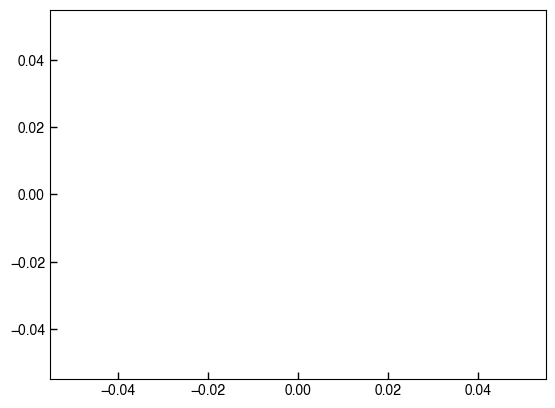

In [11]:
plt.plot()

/var/folders/m6/tlbphhsj42vb1p03003j2v340000gn/T/ipykernel_36882/789070472.py:102: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(self.filename,names=self.columns,delim_whitespace=True,skiprows=23,comment='#')


Removing 377/37631 systems at the threshold
Number of systems: 100
Max Mass Per Simulation:   nan+-nanMEarth
Removing 241/26837 systems at the threshold
Number of systems: 20
Max Mass Per Simulation:   0.144+-2.206MEarth
Removing 414/19308 systems at the threshold
Number of systems: 20
Max Mass Per Simulation:   0.436+-8.681MEarth
Removing 214/13069 systems at the threshold
Number of systems: 20
Max Mass Per Simulation:   2.615+-393.901MEarth


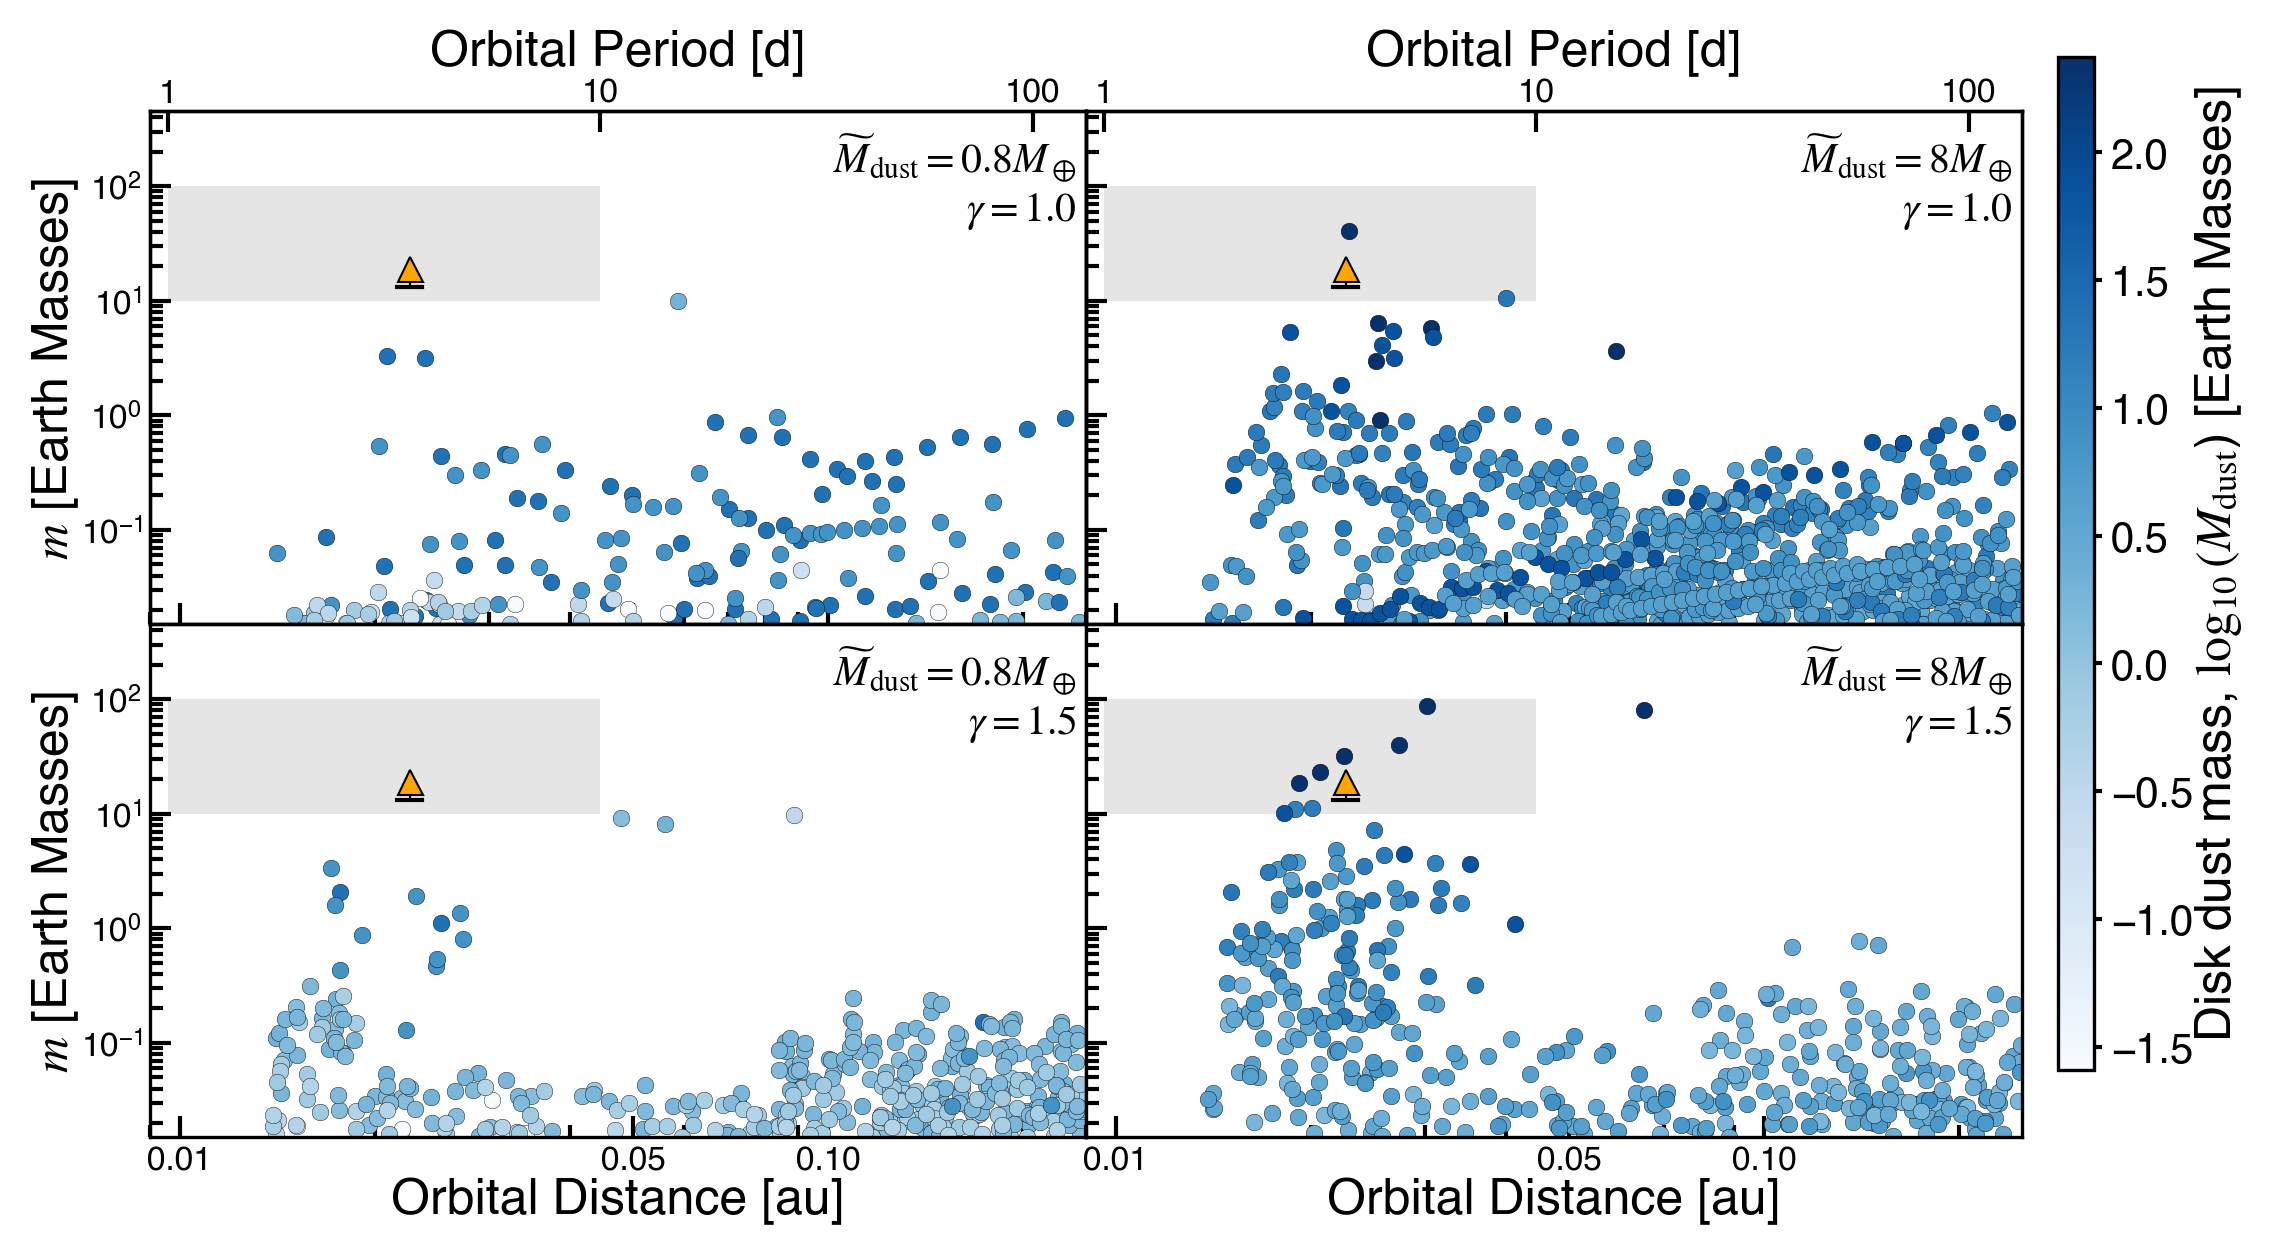

In [23]:
import matplotlib
matplotlib.rc_file(matplotlib.matplotlib_fname())
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'Helvetica'
rcParams['font.weight'] = "normal"
rcParams["axes.formatter.useoffset"] = False
rcParams['xtick.major.width']=1
rcParams['xtick.major.size']=5
rcParams['xtick.minor.width']=1
rcParams['xtick.minor.size']=3
rcParams['ytick.major.width']=1
rcParams['ytick.major.size']=5
rcParams['ytick.minor.width']=1
rcParams['ytick.minor.size']=3
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'
rcParams['axes.formatter.limits'] = -10,10

LABELFS=12
LEGENDFS=8.5

XLIM = (0.009,0.25)
YLIM = (0.015,450)


NRUNS=300
cmap = 'Blues'
l1 = '$\widetilde{M}_{\mathrm{dust}} = 0.8M_\oplus$\n$\gamma=1.0$'
l2 = '$\widetilde{M}_{\mathrm{dust}} = 0.8M_\oplus$\n$\gamma=1.5$'
l3 = '$\widetilde{M}_{\mathrm{dust}} = 8M_\oplus$\n$\gamma=1.0$'
l4 = '$\widetilde{M}_{\mathrm{dust}} = 8M_\oplus$\n$\gamma=1.5$'

PFR0 = PlanetFormResult(files[0],label=l1,q=70,color=CP[0],rthres=True)
PFR1 = PlanetFormResult(files[1],label=l2,q=7.0,color=CP[3],rthres=True)
PFR2 = PlanetFormResult(files[2],label=l3,q=70,color=CP[4],rthres=True)
PFR3 = PlanetFormResult(files[3],label=l4,q=7.0,color=CP[2],rthres=True)
m0=((PFR0.df['a(AU)']>XLIM[0])&(PFR0.df['a(AU)']<XLIM[1]))&((PFR0.df['emepla[MEarth]']>YLIM[0])&(PFR0.df['emepla[MEarth]']<YLIM[1]))
m1=((PFR1.df['a(AU)']>XLIM[0])&(PFR1.df['a(AU)']<XLIM[1]))&((PFR1.df['emepla[MEarth]']>YLIM[0])&(PFR1.df['emepla[MEarth]']<YLIM[1]))
m2=((PFR2.df['a(AU)']>XLIM[0])&(PFR2.df['a(AU)']<XLIM[1]))&((PFR2.df['emepla[MEarth]']>YLIM[0])&(PFR2.df['emepla[MEarth]']<YLIM[1]))
m3=((PFR3.df['a(AU)']>XLIM[0])&(PFR3.df['a(AU)']<XLIM[1]))&((PFR3.df['emepla[MEarth]']>YLIM[0])&(PFR3.df['emepla[MEarth]']<YLIM[1]))
PFR0.df = PFR0.df[m0]
PFR1.df = PFR1.df[m1]
PFR2.df = PFR2.df[m2]
PFR3.df = PFR3.df[m3]

fig, axx = plt.subplots(nrows=2,ncols=2,dpi=300,sharey=True,sharex=True,figsize=(8,4.5))

ax1 = axx[0,0]
bx1 = axx[0,1]
ax2 = axx[1,0]
bx2 = axx[1,1]

fig.subplots_adjust(hspace=0.,wspace=0)

ax1.set_ylabel('$m$ [Earth Masses]',fontsize=LABELFS,labelpad=0)
ax2.set_ylabel('$m$ [Earth Masses]',fontsize=LABELFS,labelpad=0)
ax2.set_xlabel('Orbital Distance [au]',fontsize=LABELFS,labelpad=0)
bx2.set_xlabel('Orbital Distance [au]',fontsize=LABELFS,labelpad=0)

ms = 1
x1 = np.log10(0.01*PFR0.df['md[Msol]'].values*ms*(aconst.M_sun.value/aconst.M_earth.value))
x2 = np.log10(0.01*PFR1.df['md[Msol]'].values*ms*(aconst.M_sun.value/aconst.M_earth.value))
x3 = np.log10(0.01*PFR2.df['md[Msol]'].values*ms*(aconst.M_sun.value/aconst.M_earth.value))
x4 = np.log10(0.01*PFR3.df['md[Msol]'].values*ms*(aconst.M_sun.value/aconst.M_earth.value))

MIN, MAX = np.min(np.concatenate([x1,x2,x3,x4])), np.max(np.concatenate([x1,x2,x3,x4]))

colors = get_cmap_colors(cmap=cmap,p=x1,pmin=MIN,pmax=MAX)


for i in range(len(PFR0.df)):
    if i == 0:
        ax1.plot(PFR0.df['a(AU)'].values[i],PFR0.df['emepla[MEarth]'].values[i],marker='o',lw=0,
             markersize=4,alpha=1,mec='black',mew=0.1,color=colors[i],label=l1)
    else:
        ax1.plot(PFR0.df['a(AU)'].values[i],PFR0.df['emepla[MEarth]'].values[i],marker='o',lw=0,
             markersize=4,alpha=1,mec='black',mew=0.1,color=colors[i])

colors = get_cmap_colors(cmap=cmap,p=x2,pmin=MIN,pmax=MAX)
for i in range(len(PFR1.df)):
    if i == 0:
        ax2.plot(PFR1.df['a(AU)'].values[i],PFR1.df['emepla[MEarth]'].values[i],marker='o',lw=0,
             markersize=4,alpha=1,mec='black',mew=0.1,color=colors[i],label=l2)
    else:
        ax2.plot(PFR1.df['a(AU)'].values[i],PFR1.df['emepla[MEarth]'].values[i],marker='o',lw=0,
             markersize=4,alpha=1,mec='black',mew=0.1,color=colors[i])

colors = get_cmap_colors(cmap=cmap,p=x3,pmin=MIN,pmax=MAX)
for i in range(len(PFR2.df)):
    if i==0:
        bx1.plot(PFR2.df['a(AU)'].values[i],PFR2.df['emepla[MEarth]'].values[i],marker='o',lw=0,
             markersize=4,alpha=1,mec='black',mew=0.1,color=colors[i],label=l3)
    else:
        bx1.plot(PFR2.df['a(AU)'].values[i],PFR2.df['emepla[MEarth]'].values[i],marker='o',lw=0,
             markersize=4,alpha=1,mec='black',mew=0.1,color=colors[i])
        
    
colors = get_cmap_colors(cmap=cmap,p=x4,pmin=MIN,pmax=MAX)
for i in range(len(PFR3.df)):
    if i==0:
        bx2.plot(PFR3.df['a(AU)'].values[i],PFR3.df['emepla[MEarth]'].values[i],marker='o',lw=0,
             markersize=4,alpha=1,mec='black',mew=0.1,color=colors[i],label=l4)
    else:
        bx2.plot(PFR3.df['a(AU)'].values[i],PFR3.df['emepla[MEarth]'].values[i],marker='o',lw=0,
             markersize=4,alpha=1,mec='black',mew=0.1,color=colors[i])
        
ax1.text(0.99,0.96,l1,fontsize=10,transform=ax1.transAxes,ha='right',va='top')
ax2.text(0.99,0.96,l2,fontsize=10,transform=ax2.transAxes,ha='right',va='top')
bx1.text(0.99,0.96,l3,fontsize=10,transform=bx1.transAxes,ha='right',va='top')
bx2.text(0.99,0.96,l4,fontsize=10,transform=bx2.transAxes,ha='right',va='top')

a1 = a_from_keplers_third_law(0.118,1)
a2 = a_from_keplers_third_law(0.118,10)

x = np.linspace(a1,a2,100)

for xx in [ax1,bx1,ax2,bx2]:
    xx.set_xscale('log')
    xx.set_yscale('log')
    xx.set_xlim(XLIM[0],XLIM[1])
    xx.set_ylim(YLIM[0],YLIM[1])
    _d = 0.001
    _l = 6
    xx.plot([0.02262-_d,0.02262+_d],[13.08,13.08],color='black',lw=1,zorder=1000)
    # Vertical line
    xx.plot([0.02262,0.02262],[13.08,13.08+_l],color='black',lw=0.5,zorder=1000)
    # Arrowhead
    xx.plot(0.02262,13.08+_l,marker='^',markersize=6,color='orange',label='',mew=0.5,lw=0,mec='black',zorder=1001)
    xx.tick_params(axis='x',labelsize=8,pad=2)
    xx.tick_params(axis='y',labelsize=8,pad=2)
    xx.minorticks_on()

f0, m1 = get_frequency(PFR0.df['a(AU)'].values,PFR0.df['emepla[MEarth]'].values,(a1,a2),(10,100),NRUNS)
f1, m2 = get_frequency(PFR1.df['a(AU)'].values,PFR1.df['emepla[MEarth]'].values,(a1,a2),(10,100),NRUNS)
f2, m3 = get_frequency(PFR2.df['a(AU)'].values,PFR2.df['emepla[MEarth]'].values,(a1,a2),(10,100),NRUNS)
f3, m4 = get_frequency(PFR3.df['a(AU)'].values,PFR3.df['emepla[MEarth]'].values,(a1,a2),(10,100),NRUNS)
ax1.fill_between(x,np.ones(100)*10,np.ones(100)*100,color='black',alpha=0.1,lw=0,label='$\eta_{\mathrm{Neptunes}}$='+'{:0.0f}%'.format(f0*100))
ax2.fill_between(x,np.ones(100)*10,np.ones(100)*100,color='black',alpha=0.1,lw=0,label='$\eta_{\mathrm{Neptunes}}$='+'{:0.0f}%'.format(f1*100))
bx1.fill_between(x,np.ones(100)*10,np.ones(100)*100,color='black',alpha=0.1,lw=0,label='$\eta_{\mathrm{Neptunes}}$='+'{:0.0f}%'.format(f2*100))   
bx2.fill_between(x,np.ones(100)*10,np.ones(100)*100,color='black',alpha=0.1,lw=0,label='$\eta_{\mathrm{Neptunes}}$='+'{:0.0f}%'.format(f3*100))   

xc = 0.010
yc = 11

_ax1 = ax1.twiny()
_bx1 = bx1.twiny()
_ax1.tick_params(axis='x',labelsize=8,pad=0.5)
_bx1.tick_params(axis='x',labelsize=8,pad=0.5)
_ax1.set_xscale('log')
_bx1.set_xscale('log')

new_tick_locations = np.array([1,10,100])
def tick_function(x):
    return a_from_keplers_third_law(0.118,x)
_ax1.set_xlim(ax1.get_xlim())
_ax1.set_xticks(tick_function(new_tick_locations))
_ax1.set_xticklabels(new_tick_locations)
_ax1.minorticks_off()

_bx1.set_xlim(bx1.get_xlim())
_bx1.set_xticks(tick_function(new_tick_locations))
_bx1.set_xticklabels(new_tick_locations)
_bx1.minorticks_off()

_ax1.set_xlabel('Orbital Period [d]',fontsize=LABELFS,labelpad=3)
_bx1.set_xlabel('Orbital Period [d]',fontsize=LABELFS,labelpad=3)

for xx in [ax1,bx1,ax2,bx2]:
    xx.minorticks_on()
    
for xx in [ax2,bx2]:
    xx.set_xticks([0.01,0.05,0.1])
    xx.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
fig.subplots_adjust(left=0.12,top=0.84,bottom=0.08,right=0.9)

cax = fig.add_axes([0.915, 0.13, 0.015, 0.75])
norm = matplotlib.colors.Normalize(vmin=MIN, vmax=MAX)
cm = plt.get_cmap(cmap)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, norm=norm)
cax.axes.tick_params(width=1,length=2,direction='out',pad=2)
cax.set_ylabel('Disk dust mass, $\log_{10}(M_{\mathrm{dust}}$) [Earth Masses]',fontsize=LABELFS,labelpad=0)

fig.savefig('fig_03_models.pdf',dpi=300)